In [2]:
! pip install tensorflow pandas scikit-learn matplotlib tqdm --quiet

In [3]:
!pip install bayesian-optimization

# Predicción de Regalías con LSTM Multivariado
### Tesis de Maestría en Ciencia de Datos
Este notebook implementa una red neuronal LSTM multivariada para predecir regalías mensuales por artista.
Se entrenan modelos por artista, se calculan métricas y se exportan los resultados para visualización en Power BI.

In [4]:
import pandas as pd

file_id = '1h97krjdPVuKszy9NVcZiWNQuPUu3ICyc' #version con artist_id
url = f'https://drive.google.com/uc?export=download&id={file_id}'
df = pd.read_csv(url)
df['fecha'] = pd.to_datetime(df['fecha'], format='%m/%d/%Y')
df.head()

,artist_id,fecha,royalties,instagram_followers,twitter_followers,track_release,sentiment,seguidores_menciones,cant_posteos,cant_comentarios,mean_royalties_6m,std_instagram_followers_6m,growth_twitter_followers,growth_instagram_followers,sum_track_releases_6m,mean_sentiment_3m,sum_seguidores_menciones_3m,month
0,A01,2022-08-01,9181.530,6157095,2725818,0,0.000000,0,0,0,9181.530000,0.0000,0,0,0,0.000000,0,8
1,A01,2022-09-01,11326.315,6267740,2724330,0,0.000000,0,2,40,10253.922500,78237.8298,-1488,110645,0,0.000000,0,9
2,A01,2022-10-01,8111.670,6387042,2721716,0,0.555556,0,1,27,9539.838333,115000.6565,-2614,119302,0,0.185185,0,10
3,A01,2022-11-01,8916.570,6460584,2718405,1,0.610169,0,3,118,9384.021250,133558.2623,-3311,73542,1,0.388575,0,11
4,A01,2022-12-01,12755.920,6562667,2713392,1,0.538462,0,1,39,10058.401000,159183.7579,-5013,102083,2,0.568062,0,12


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from bayes_opt import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm   # o from tqdm import tqdm

# ==============================
# Función para crear secuencias
# ==============================
def create_sequences(X, y, lookback=3):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)


# ==============================
# Parámetros globales
# ==============================
pbounds = {
    "lookback": (3, 12),       # entero
    "units": (10, 150),        # entero
    "dropout": (0.0, 0.5),     # continuo
    "epochs": (50, 150)        # entero
}

resultados_lstm_bo = []

# ==============================
# Loop por artista
# ==============================
for artist_id, group in tqdm(df.groupby("artist_id")):
    group = group.sort_values("fecha")
    if len(group) < 30:
        continue

    features = [
        "instagram_followers", "twitter_followers", "track_release", "sentiment",
        "seguidores_menciones", "cant_posteos", "cant_comentarios",
        "mean_royalties_6m", "std_instagram_followers_6m",
        "growth_twitter_followers", "growth_instagram_followers",
        "sum_track_releases_6m", "mean_sentiment_3m",
        "sum_seguidores_menciones_3m", "month"
    ]
    target = "royalties"

    # Normalización
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(group[features])
    y_scaled = scaler_y.fit_transform(group[[target]])

    # ==============================
    # Función objetivo para BO
    # ==============================
    def train_evaluate_lstm(lookback, units, dropout, epochs):
        lookback = int(round(lookback))
        units = int(round(units))
        epochs = int(round(epochs))

        X_seq, y_seq = create_sequences(X_scaled, y_scaled, lookback)
        if len(X_seq) < 24:
            return -1e6  # penalización si la serie es muy corta

        step_size = 6     # bloques de validación
        train_initial = 18
        errores = []

        for start in range(train_initial, len(X_seq) - step_size, step_size):
            X_train, y_train = X_seq[:start], y_seq[:start]
            X_val, y_val = X_seq[start:start + step_size], y_seq[start:start + step_size]

            model = Sequential()
            model.add(LSTM(units=units, activation="relu", input_shape=(lookback, len(features))))
            if dropout > 0:
                model.add(Dropout(dropout))
            model.add(Dense(1))
            model.compile(optimizer="adam", loss="mse")

            # Entrenamiento
            model.fit(X_train, y_train, epochs=epochs, batch_size=16, verbose=0)

            # Validación
            y_pred = model.predict(X_val, verbose=0)
            y_val_inv = scaler_y.inverse_transform(y_val)
            y_pred_inv = scaler_y.inverse_transform(y_pred)

            rmse = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))
            errores.append(rmse)

        if not errores:
            return -1e6

        return -np.mean(errores)  # BO maximiza → devolvemos negativo del RMSE medio

    # ==============================
    # Optimización bayesiana
    # ==============================
    optimizer = BayesianOptimization(
        f=train_evaluate_lstm,
        pbounds=pbounds,
        random_state=42,
        verbose=0
    )

    optimizer.maximize(init_points=3, n_iter=10)

    best_params = optimizer.max["params"]
    best_params["lookback"] = int(round(best_params["lookback"]))
    best_params["units"] = int(round(best_params["units"]))
    best_params["epochs"] = int(round(best_params["epochs"]))
    best_params["dropout"] = float(best_params["dropout"])

    resultados_lstm_bo.append({
        "Artist_ID": artist_id,
        **best_params,
        "Best_RMSE": -optimizer.max["target"]
    })


# ==============================
# Consolidar resultados
# ==============================
df_resultados_lstm_bo = pd.DataFrame(resultados_lstm_bo)
df_resultados_lstm_bo.to_csv("resultados_lstm.csv", index=False)
print("✅ Optimización completa. Resultados guardados en resultados_lstm.csv.")


  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

✅ Optimización completa. Resultados guardados en resultados_lstm.csv.


In [ ]:
print(df_resultados_lstm_bo)

   Artist_ID  lookback  units   dropout  epochs      Best_RMSE
0        A01         3     49  0.000000     133     683.380855
1        A02         6    143  0.365997     110     775.944647
2        A03         4    150  0.500000      68   52865.836408
3        A04         3     44  0.500000      50     333.005402
4        A05         6     32  0.137095     137   37634.328128
5        A06         3     33  0.500000     144   20192.426486
6        A07         8    109  0.010292     147   34442.145214
7        A08         3     65  0.000000     113    1320.946962
8        A09         3     10  0.500000     141    2252.925250
9        A10         6    142  0.059199     111    2142.710222
10       A11        12     62  0.500000     150     937.559930
11       A12         9     17  0.075249     133     239.164909
12       A13         8    109  0.012410     147  112306.174312
13       A14         5     31  0.129473     138   40235.406087
14       A15         6    143  0.347426     109   14130

# Hiperparametros Elegidos

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tqdm.notebook import tqdm


# ============================
# 1️⃣ Leer hiperparámetros óptimos desde CSV
# ============================
df_best = pd.read_csv("resultados_lstm.csv")

best_params_por_artista = {
    row["Artist_ID"]: {
        "lookback": int(row["lookback"]),
        "units": int(row["units"]),
        "dropout": float(row["dropout"]),
        "epochs": int(row["epochs"])
    }
    for _, row in df_best.iterrows()
}


# ============================
# 2️⃣ Función para crear secuencias
# ============================
def create_sequences(X, y, lookback=3):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)


# ============================
# 3️⃣ Entrenamiento + validación walk-forward
# ============================
resultados_lstm = []
predicciones_lstm = []

for artist_id, group in tqdm(df.groupby("artist_id")):
    if artist_id not in best_params_por_artista:
        continue

    group = group.sort_values("fecha")
    if len(group) < 24:
        continue

    features = [
        "instagram_followers", "twitter_followers", "track_release", "sentiment",
        "seguidores_menciones", "cant_posteos", "cant_comentarios",
        "mean_royalties_6m", "std_instagram_followers_6m",
        "growth_twitter_followers", "growth_instagram_followers",
        "sum_track_releases_6m", "mean_sentiment_3m",
        "sum_seguidores_menciones_3m", "month"
    ]
    target = "royalties"

    # Normalización
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(group[features])
    y_scaled = scaler_y.fit_transform(group[[target]])

    params = best_params_por_artista[artist_id]
    lookback = params["lookback"]

    X_seq, y_seq = create_sequences(X_scaled, y_scaled, lookback)
    if len(X_seq) < 18:
        continue

    step_size = 6
    train_initial = 18
    errores_rmse, errores_mae, errores_mape = [], [], []

    # 🔁 Walk-forward loop (ajustado para incluir el final)
    for start in range(train_initial, len(X_seq), step_size):
        end = min(start + step_size, len(X_seq))

        X_train, y_train = X_seq[:start], y_seq[:start]
        X_val, y_val = X_seq[start:end], y_seq[start:end]

        # Evita entrenar si no hay suficientes datos
        if len(X_val) == 0:
            continue

        model = Sequential()
        model.add(LSTM(
            units=params["units"],
            activation="relu",
            input_shape=(lookback, len(features))
        ))
        if params["dropout"] > 0:
            model.add(Dropout(params["dropout"]))
        model.add(Dense(1))
        model.compile(optimizer="adam", loss="mse")

        model.fit(
            X_train, y_train,
            epochs=params["epochs"],
            verbose=0,
            batch_size=16
        )

        y_pred = model.predict(X_val, verbose=0)
        y_val_inv = scaler_y.inverse_transform(y_val)
        y_pred_inv = scaler_y.inverse_transform(y_pred)

        # Métricas por bloque
        rmse = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))
        mae = mean_absolute_error(y_val_inv, y_pred_inv)
        mape = mean_absolute_percentage_error(y_val_inv, y_pred_inv)

        errores_rmse.append(rmse)
        errores_mae.append(mae)
        errores_mape.append(mape)

        # Fechas de este bloque
        fechas_val = group["fecha"].values[lookback + start : lookback + end]
        for i in range(len(y_pred_inv)):
            predicciones_lstm.append({
                "artist_id": artist_id,
                "fecha": fechas_val[i],
                "royalties_real": y_val_inv[i][0],
                "royalties_pred": y_pred_inv[i][0],
                "modelo": "LSTM"
            })

    # Promedio de todos los bloques
    if errores_rmse:
        resultados_lstm.append({
            "Artist_ID": artist_id,
            "Modelo": "LSTM",
            "MSE": np.mean(np.array(errores_rmse) ** 2),
            "MAE": np.mean(errores_mae),
            "RMSE": np.mean(errores_rmse),
            "MAPE": np.mean(errores_mape)
        })


# ============================
# 4️⃣ Guardar resultados
# ============================
df_resultados_lstm = pd.DataFrame(resultados_lstm)
df_preds = pd.DataFrame(predicciones_lstm)

df_resultados_lstm.to_csv("lstm_metrics_por_artista.csv", index=False)
df_preds.to_csv("lstm_predicciones_para_powerbi.csv", index=False)

print("✅ Walk-forward completado.")
print("Métricas:", df_resultados_lstm.shape)
print("Predicciones:", df_preds.shape)


  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

✅ Walk-forward completado.
Métricas: (15, 6)
Predicciones: (176, 5)


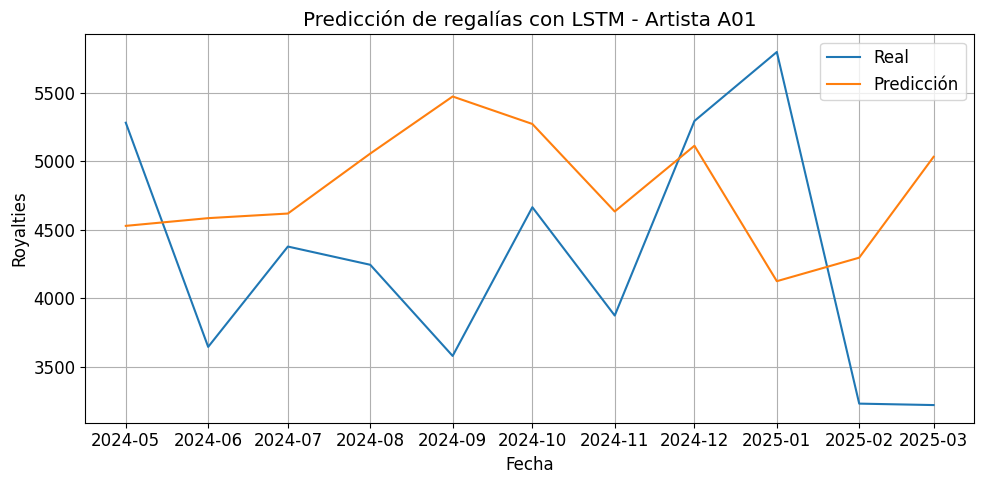

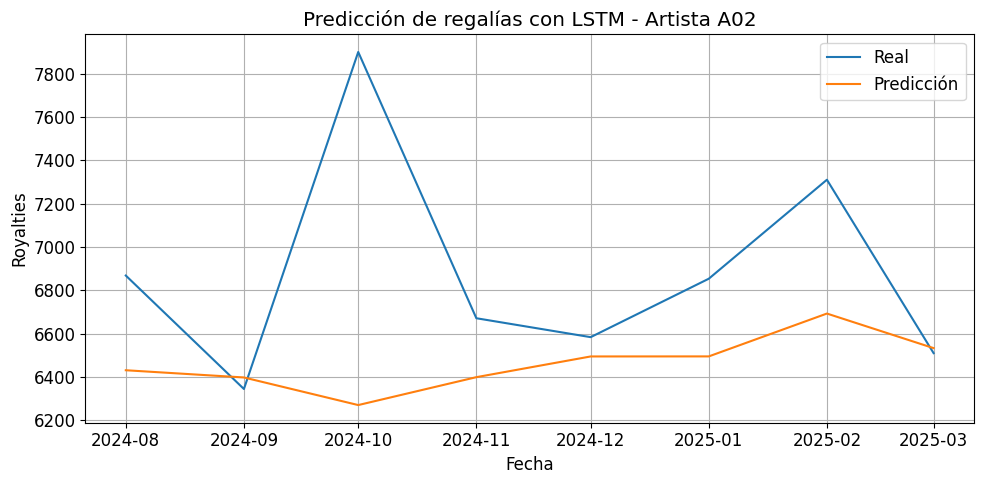

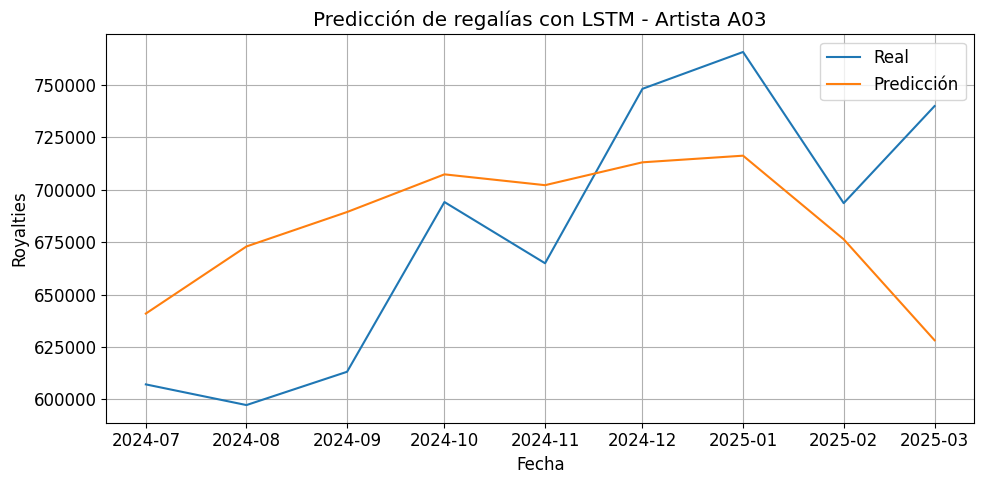

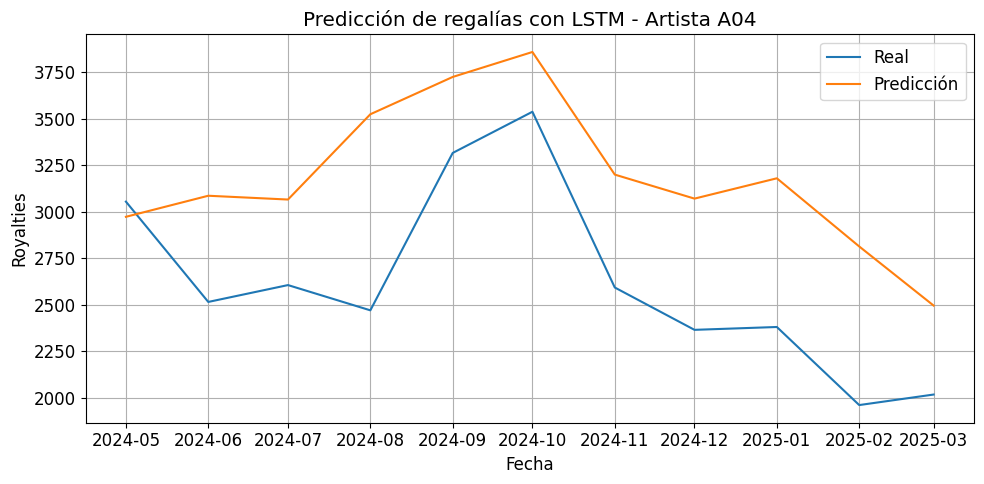

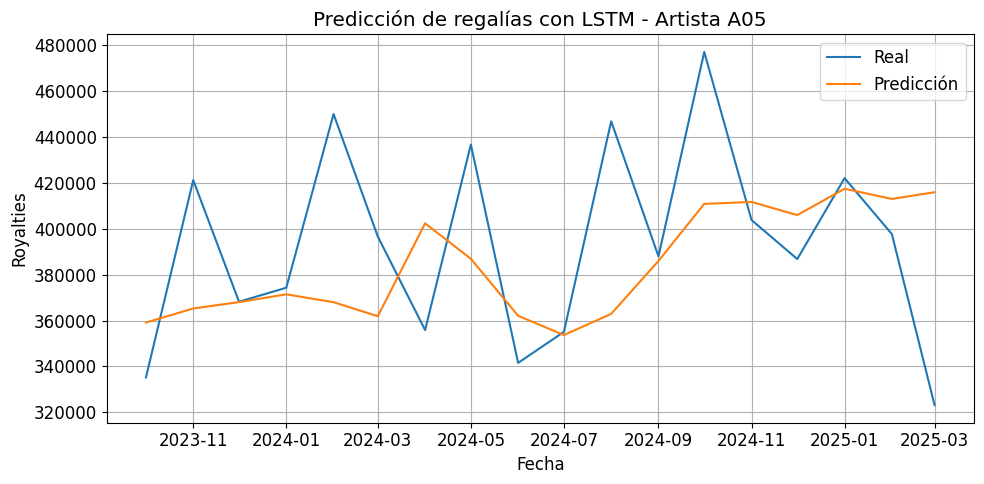

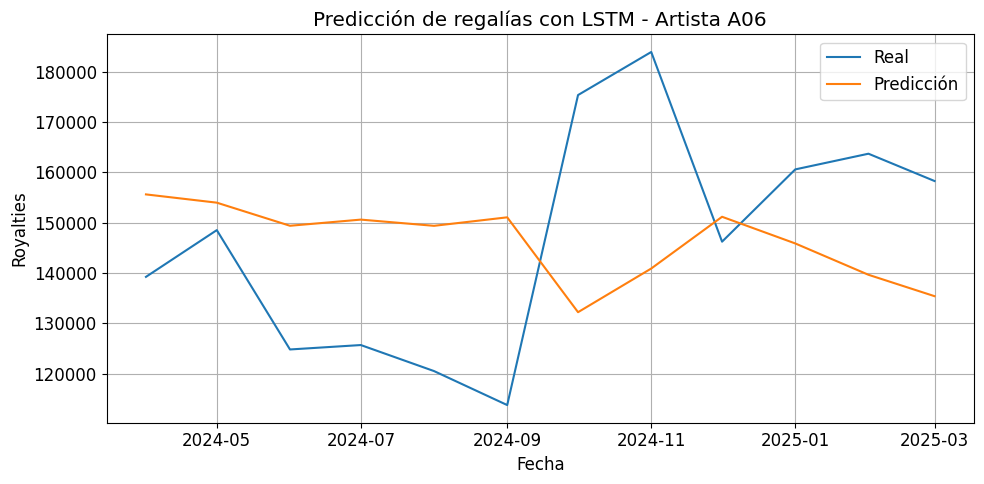

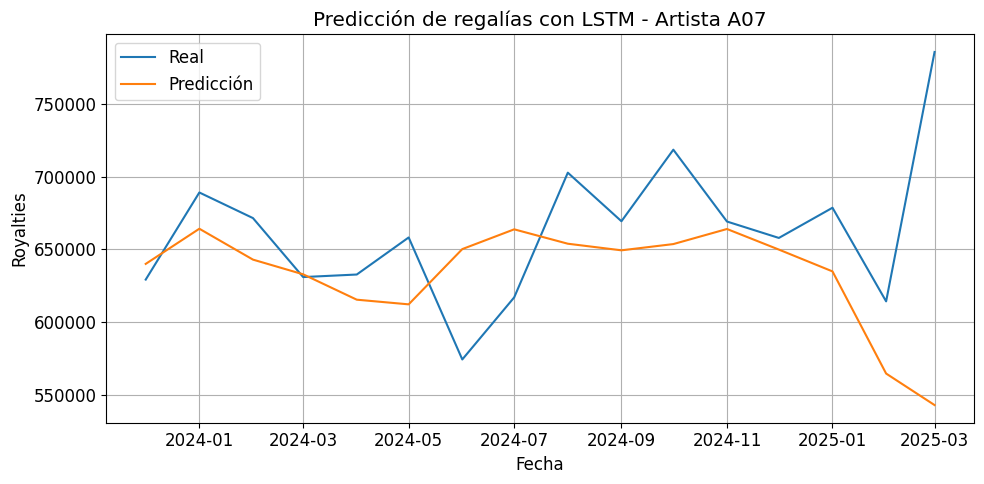

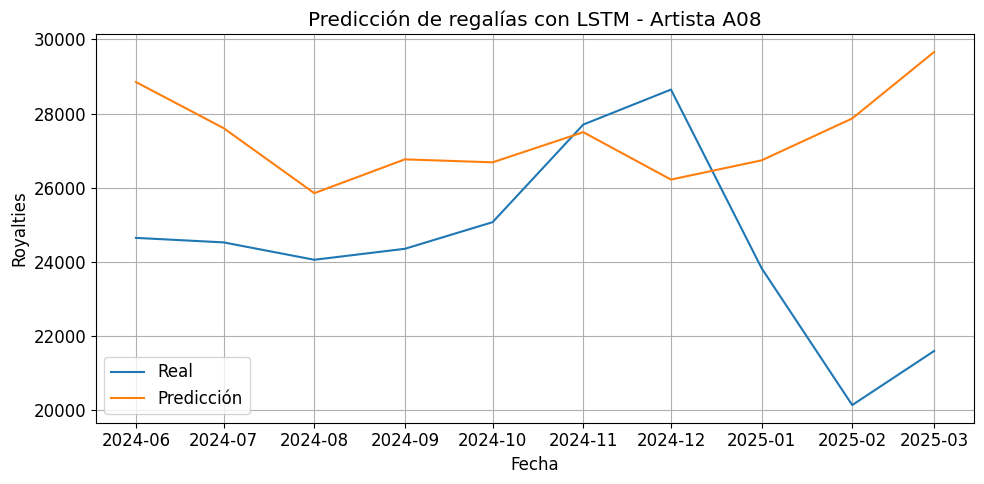

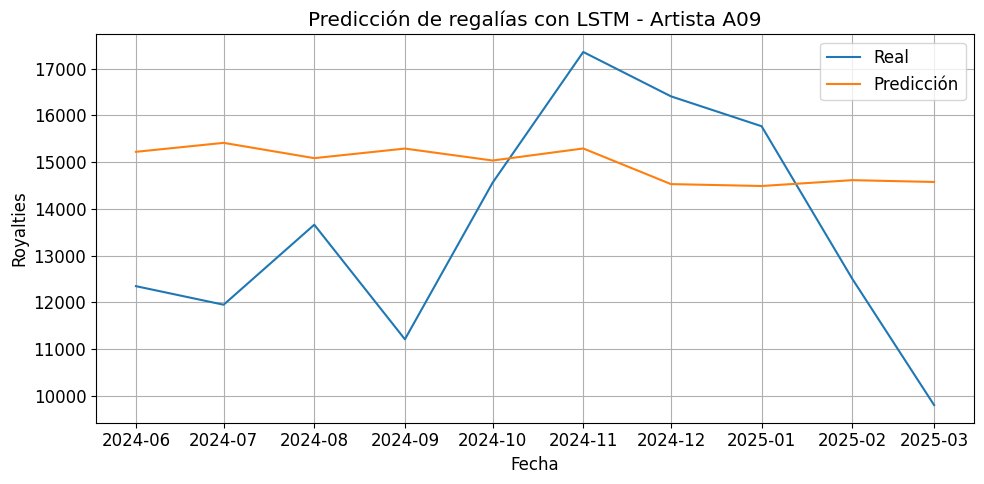

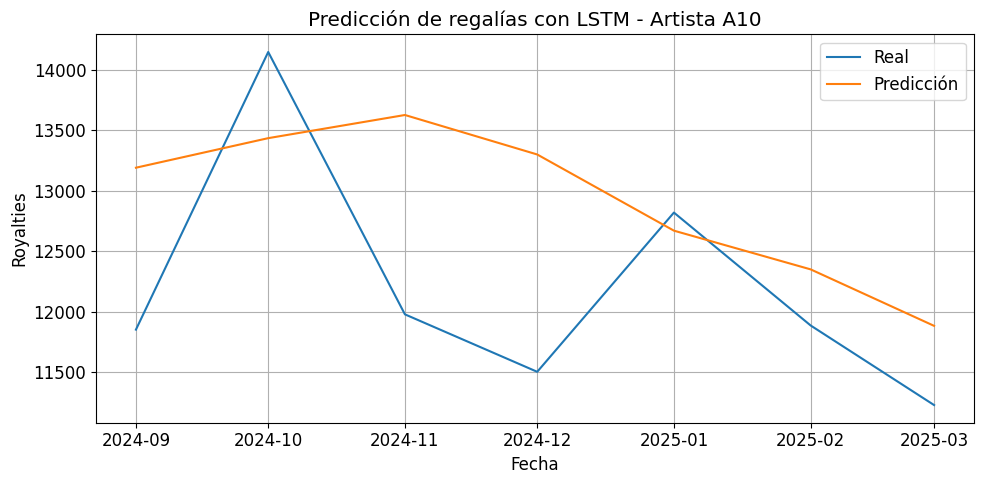

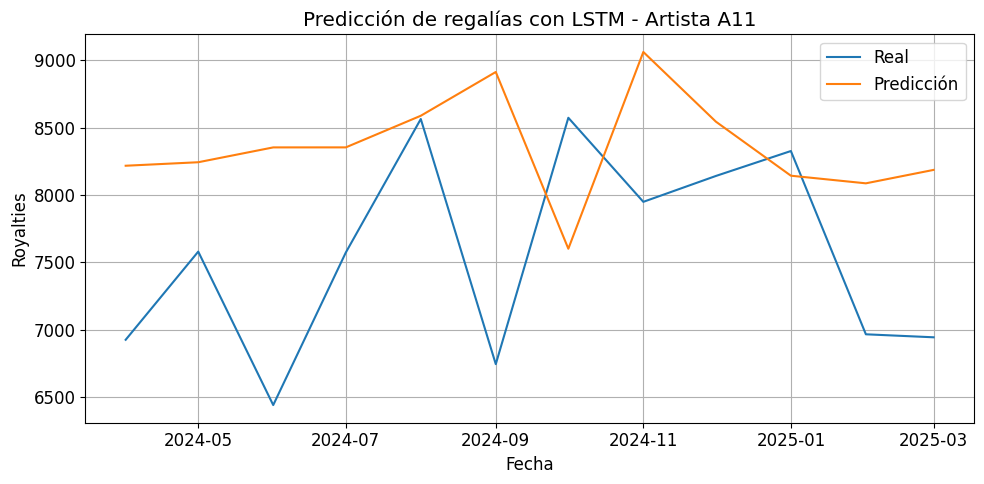

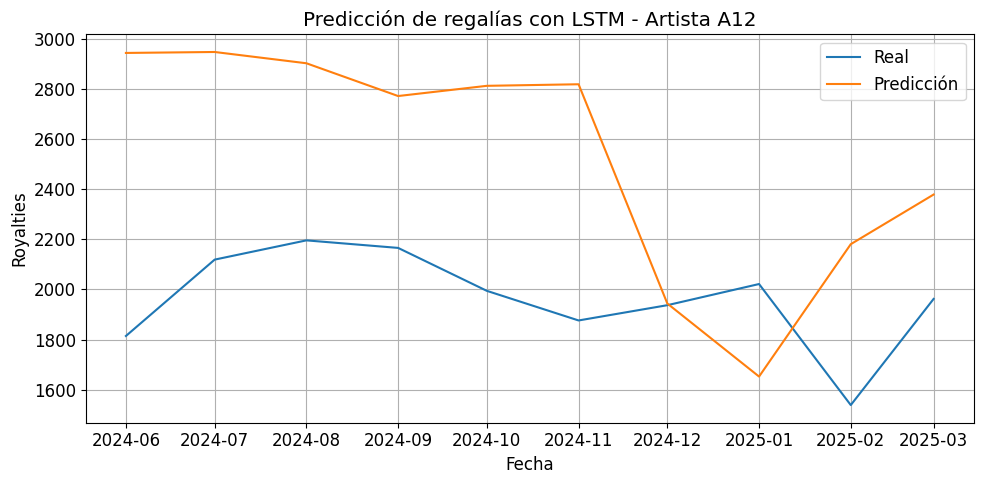

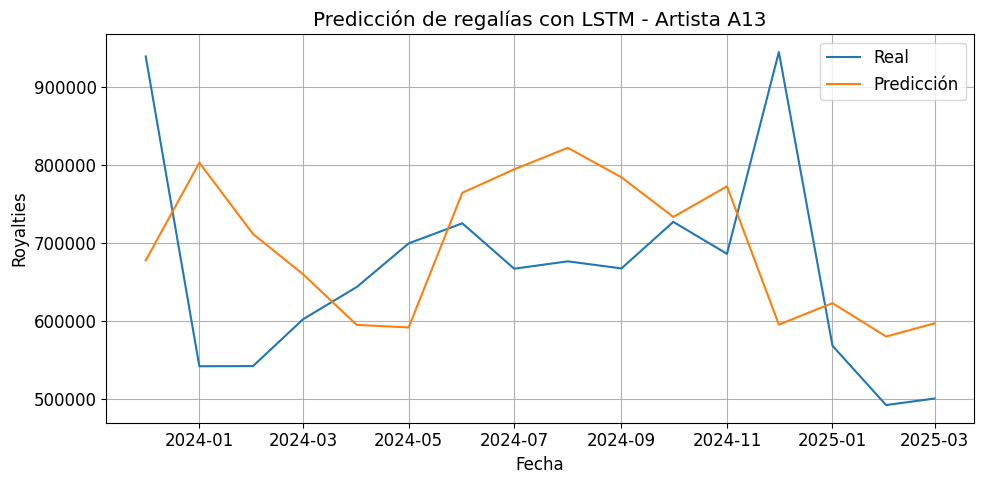

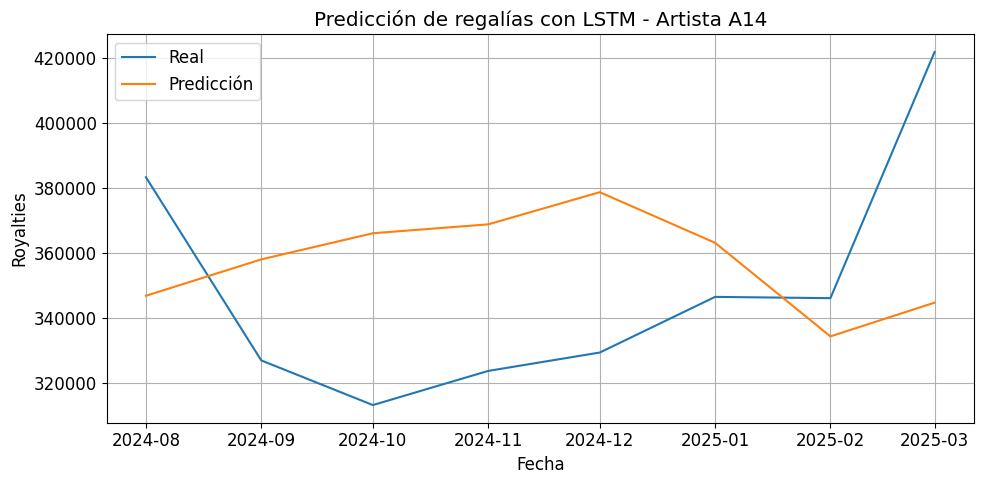

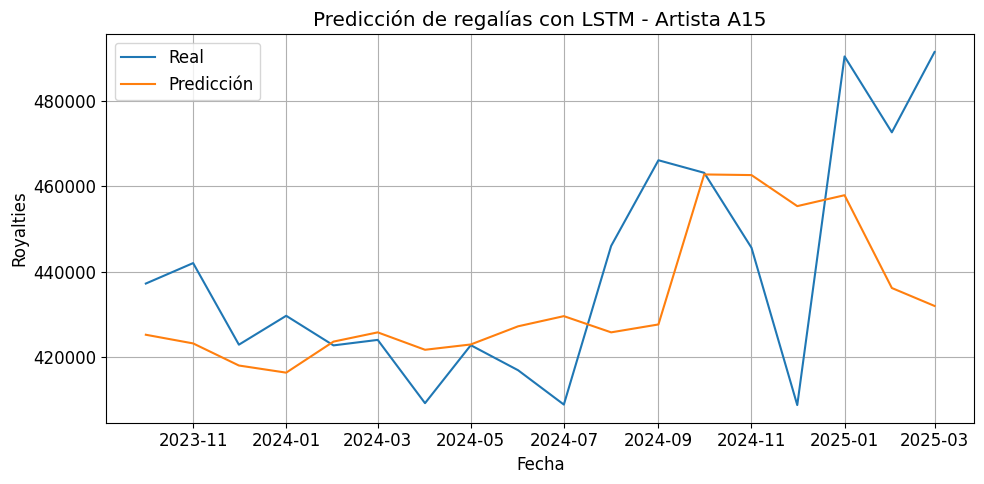

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar predicciones
df_preds = pd.read_csv("lstm_predicciones_para_powerbi.csv")
df_preds['fecha'] = pd.to_datetime(df_preds['fecha'])

# Configuración global de fuente
plt.rcParams.update({'font.size': 12})

def plot_lstm_predictions(df_preds):
    """
    Genera un gráfico de reales vs predichos para cada artista en df_preds.
    """
    for artist in df_preds["artist_id"].unique():
        subset = df_preds[df_preds["artist_id"] == artist]

        plt.figure(figsize=(10,5))
        plt.plot(subset["fecha"], subset["royalties_real"], label="Real")#, color="blue")
        plt.plot(subset["fecha"], subset["royalties_pred"], label="Predicción")#, color="orange")
        plt.title(f"Predicción de regalías con LSTM - Artista {artist}")
        plt.xlabel("Fecha")
        plt.ylabel("Royalties")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Ejecutar función
plot_lstm_predictions(df_preds)


## Forecast

Como XGBoost, LSTM no "sabe" el futuro. Para predecir más de 1 mes, hay que predecir el siguiente mes, usar esa predicción como input, y repetir (rolling forecast).

También hay que escalar los datos para LSTM (usamos MinMaxScaler generalmente).

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tqdm.notebook import tqdm

# Fuente global para la tesis
plt.rcParams.update({'font.size': 12})

# ---------------- helpers de formato ----------------
def _fmt_money(x):
    if x is None or not np.isfinite(x): return "—"
    if x >= 1e6:  return f"{x/1e6:,.2f} M"
    if x >= 1e3:  return f"{x/1e3:,.2f} k"
    return f"{x:,.0f}"

def _human_scale(max_val):
    if max_val >= 1e6: return 1e6, "Royalties (millones)"
    if max_val >= 1e3: return 1e3, "Royalties (miles)"
    return 1, "Royalties"

# ==============================
# Función principal: Forecast LSTM por artista (SIN graficar)
# ==============================
def forecast_lstm_por_artista(df, artist_id, params, steps=6):
    """
    Entrena un LSTM multivariado por artista y genera un forecast rolling (6 pasos).
    Devuelve un DataFrame con columnas: artist_id, fecha_prediccion, royalties_forecast.
    """

    # Filtrar datos del artista
    df_artista = df[df['artist_id'] == artist_id].copy().sort_values('fecha')
    if df_artista.empty or df_artista['royalties'].notna().sum() < 3:
        raise ValueError(f'El artista {artist_id} no tiene datos suficientes.')

    df_artista['fecha'] = pd.to_datetime(df_artista['fecha'])
    df_artista = df_artista.set_index('fecha').asfreq('MS')

    # Definir features y target
    features = [
        "instagram_followers", "twitter_followers", "track_release", "sentiment",
        "seguidores_menciones", "cant_posteos", "cant_comentarios",
        "mean_royalties_6m", "std_instagram_followers_6m",
        "growth_twitter_followers", "growth_instagram_followers",
        "sum_track_releases_6m", "mean_sentiment_3m",
        "sum_seguidores_menciones_3m", "month"
    ]
    target = "royalties"

    # month desde el índice (por si no está)
    df_artista["month"] = df_artista.index.month

    # Normalización
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(df_artista[features])
    y_scaled = scaler_y.fit_transform(df_artista[[target]])

    # Hiperparámetros específicos del artista
    lookback = int(params.get("lookback", 3))
    units    = int(params.get("units", 50))
    dropout  = float(params.get("dropout", 0.0))
    epochs   = int(params.get("epochs", 50))

    # Crear secuencias (multivariado)
    X, y = [], []
    for i in range(lookback, len(X_scaled)):
        X.append(X_scaled[i-lookback:i])
        y.append(y_scaled[i])
    X, y = np.array(X), np.array(y)

    # Modelo
    model = Sequential()
    model.add(LSTM(units, activation="relu", input_shape=(lookback, len(features))))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")

    # Entrenar con todos los datos disponibles
    model.fit(X, y, epochs=epochs, verbose=0, batch_size=16)

    # ==============================
    # Forecast rolling (6 pasos)
    # ==============================
    last_known = X_scaled[-lookback:].copy()
    last_date = df_artista.index[-1]
    forecasts = []

    for step in range(steps):
        X_input = last_known.reshape((1, lookback, len(features)))
        pred_scaled = model.predict(X_input, verbose=0)
        pred_royalties = scaler_y.inverse_transform(pred_scaled)[0][0]

        pred_date = last_date + pd.DateOffset(months=1)
        forecasts.append({
            "artist_id": artist_id,
            "fecha_prediccion": pred_date,
            "royalties_forecast": float(pred_royalties)
        })

        # Simular valores exógenos futuros (crecen +1% mensual)
        last_row = df_artista.iloc[-1].copy()
        simulated = last_row.copy()
        simulated["instagram_followers"] *= 1.01 ** (step + 1)
        simulated["twitter_followers"]   *= 1.01 ** (step + 1)
        simulated["track_release"] = 0
        simulated["month"] = pred_date.month

        X_new = scaler_X.transform(simulated[features].to_frame().T)
        last_known = np.vstack([last_known[1:], X_new])
        last_date = pred_date

    forecast_df = pd.DataFrame(forecasts)
    return forecast_df


# ==============================
# Leer hiperparámetros óptimos desde CSV
# ==============================
df_best = pd.read_csv("resultados_lstm.csv")
best_params_por_artista = {
    row["Artist_ID"]: {
        "lookback": int(row["lookback"]),
        "units": int(row["units"]),
        "dropout": float(row["dropout"]),
        "epochs": int(row["epochs"])
    }
    for _, row in df_best.iterrows()
}

# ==============================
# Generación de forecasts (cálculo) — sin graficar
# ==============================
lista_artistas = df['artist_id'].unique()
lista_forecasts = []

for artist_id in tqdm(lista_artistas, desc="LSTM forecasts"):
    if artist_id not in best_params_por_artista:
        print(f"⚠️ Saltando {artist_id}: no hay hiperparámetros en BO")
        continue
    try:
        fc_df = forecast_lstm_por_artista(
            df, artist_id,
            steps=6,
            params=best_params_por_artista[artist_id]
        )
        lista_forecasts.append(fc_df)
    except Exception as e:
        print(f"⚠️ Error en {artist_id}: {e}")

# Consolidar resultados y guardar CSV
df_forecasts_consolidado = pd.concat(lista_forecasts, ignore_index=True) if lista_forecasts else pd.DataFrame()
df_forecasts_consolidado.to_csv("lstm_forecast_royalties_artistas.csv", index=False)

print("✅ Forecasts generados:", df_forecasts_consolidado.shape)



LSTM forecasts:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

✅ Forecasts generados: (90, 3)


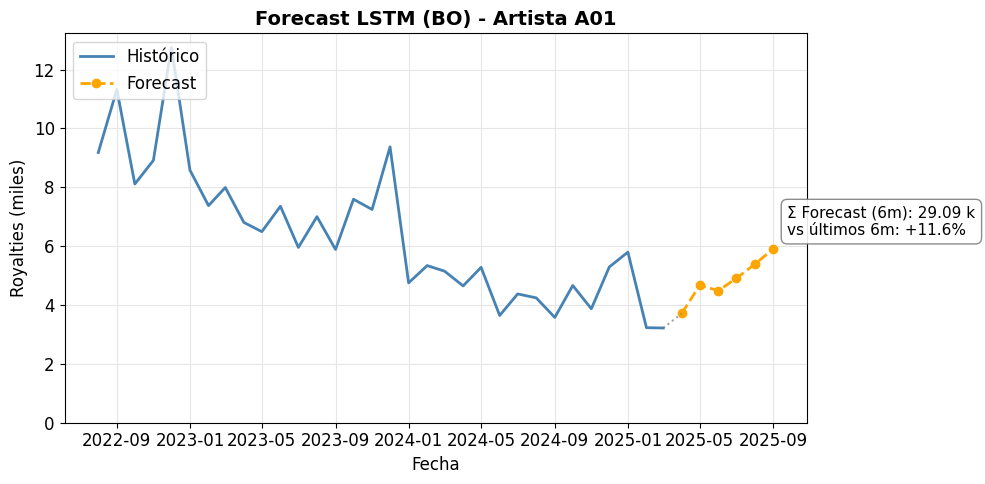

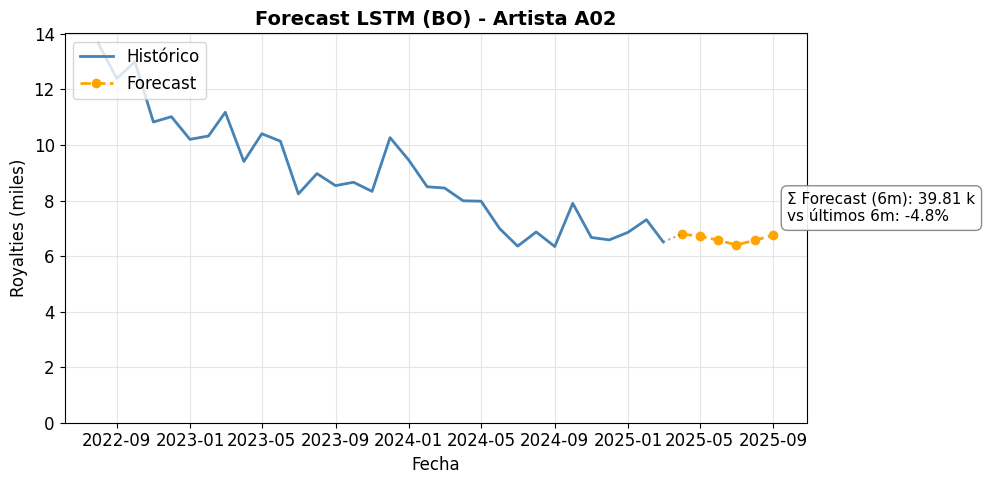

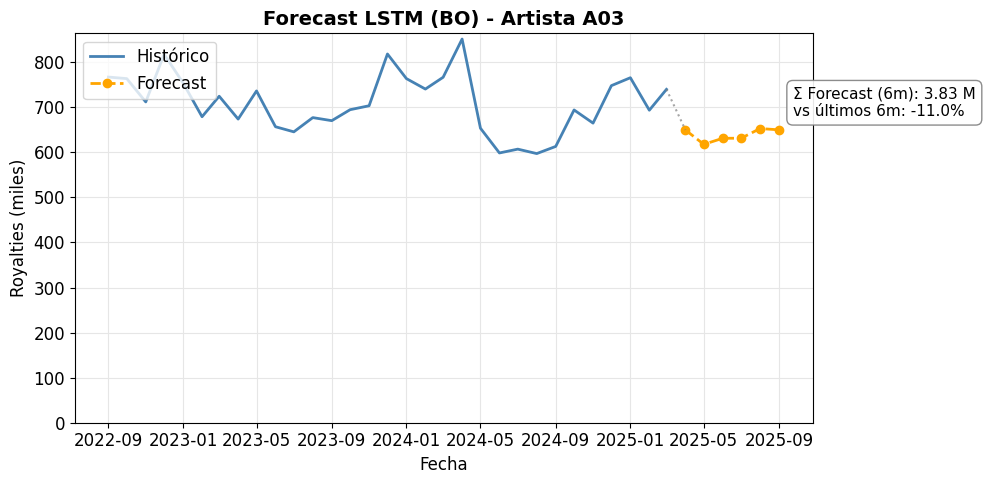

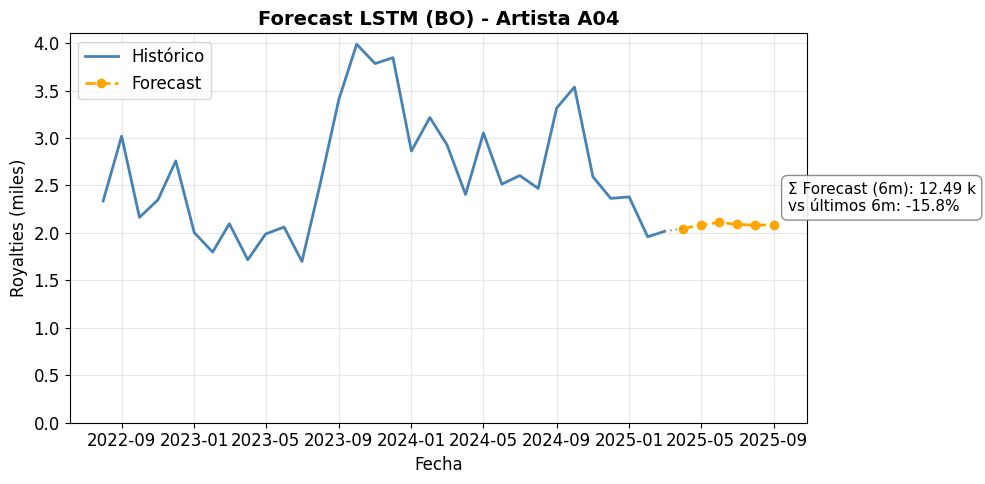

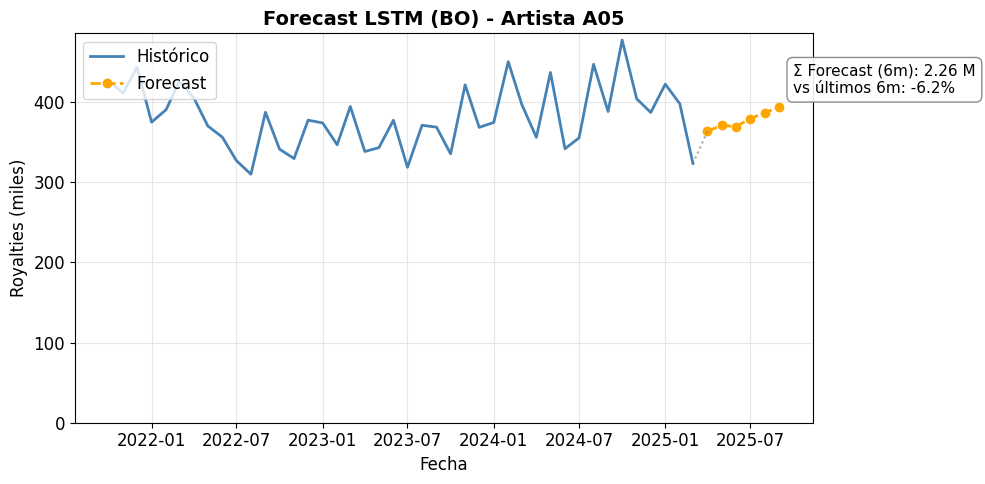

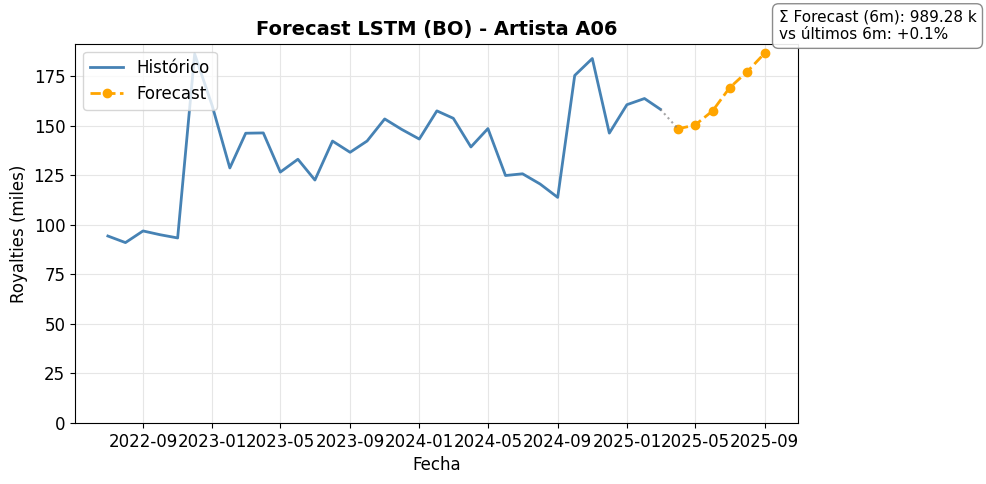

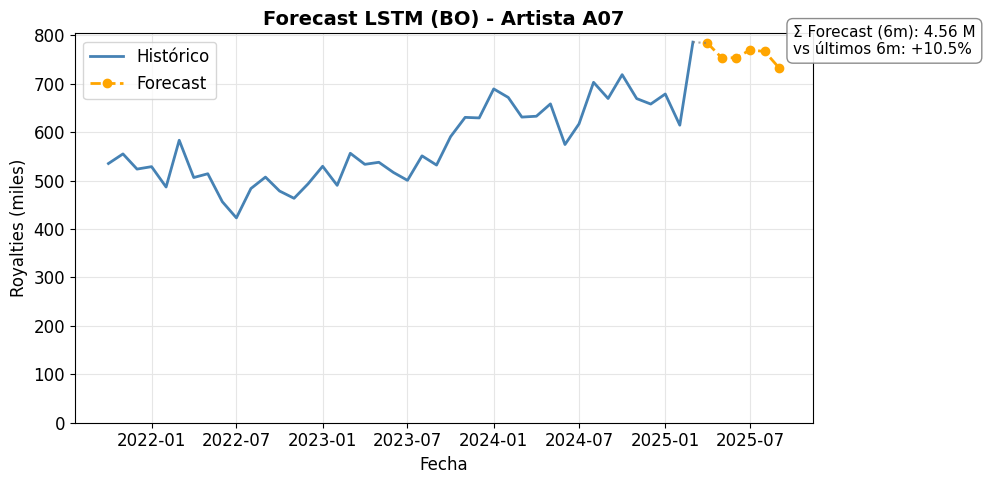

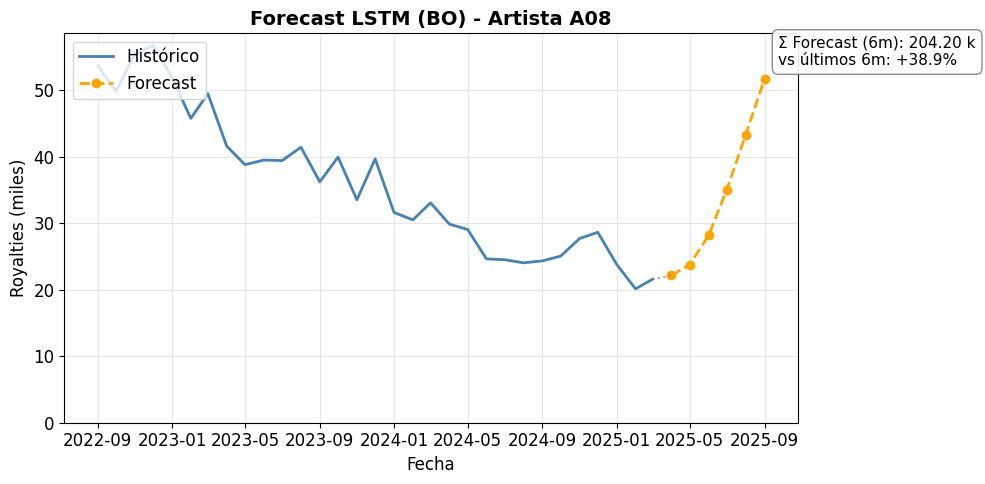

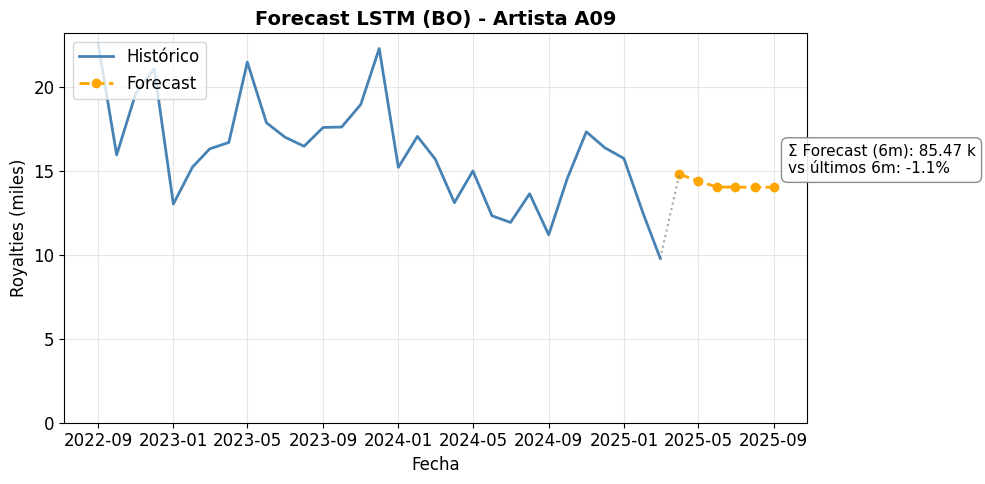

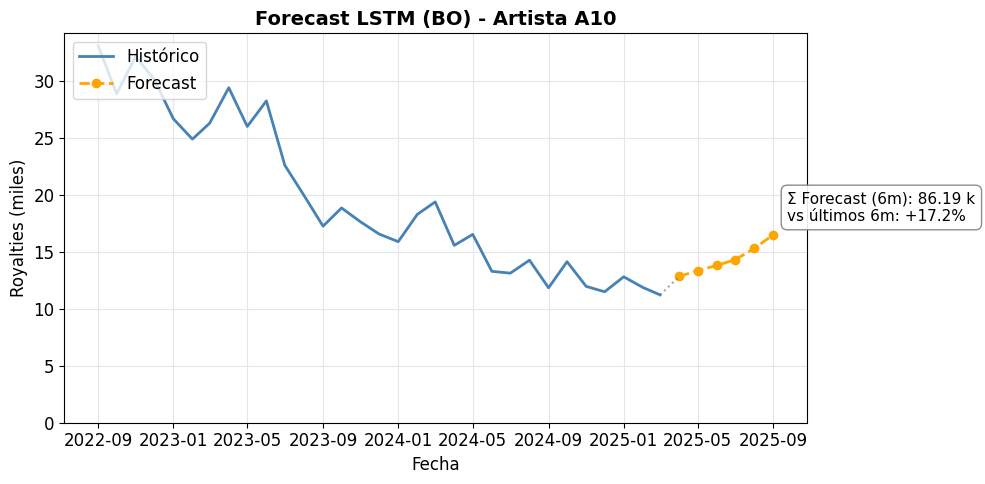

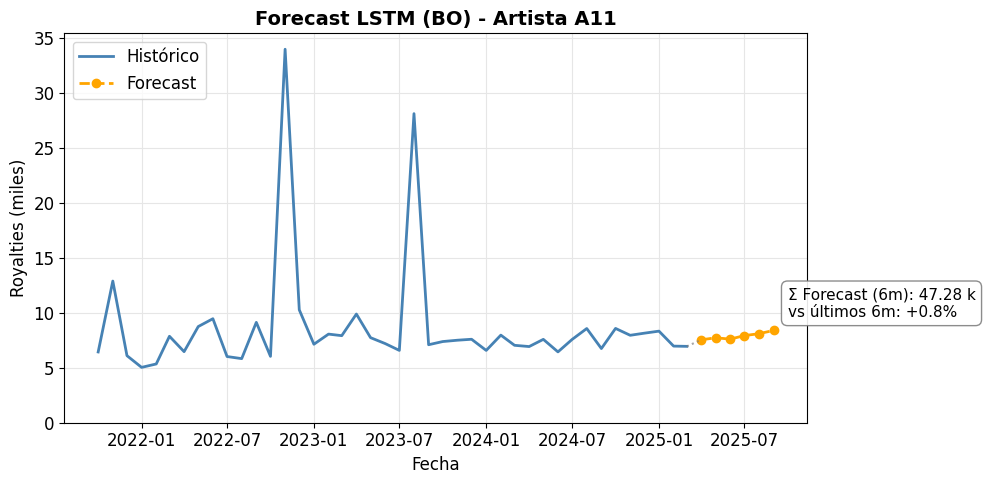

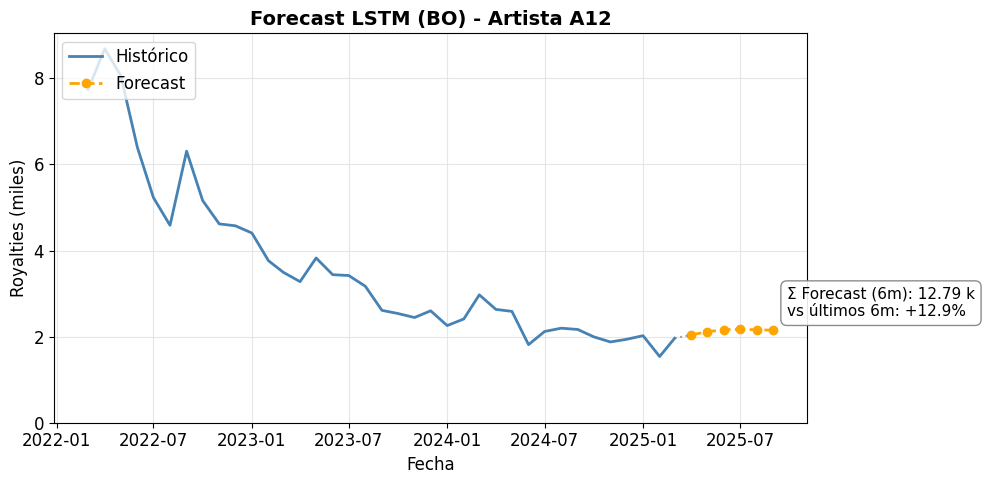

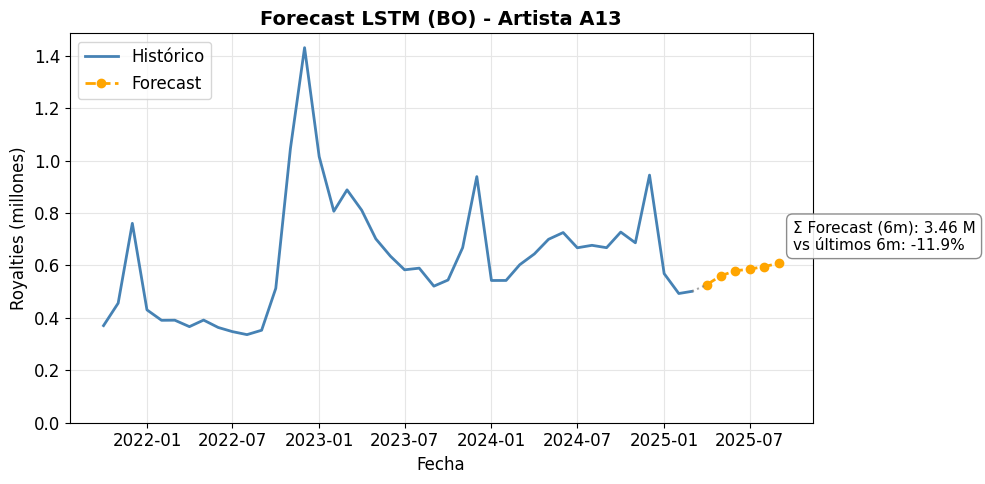

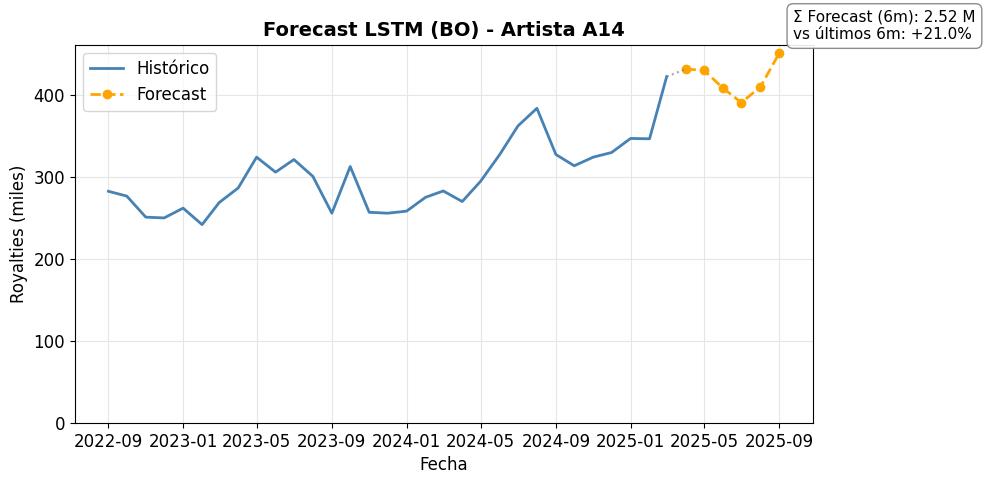

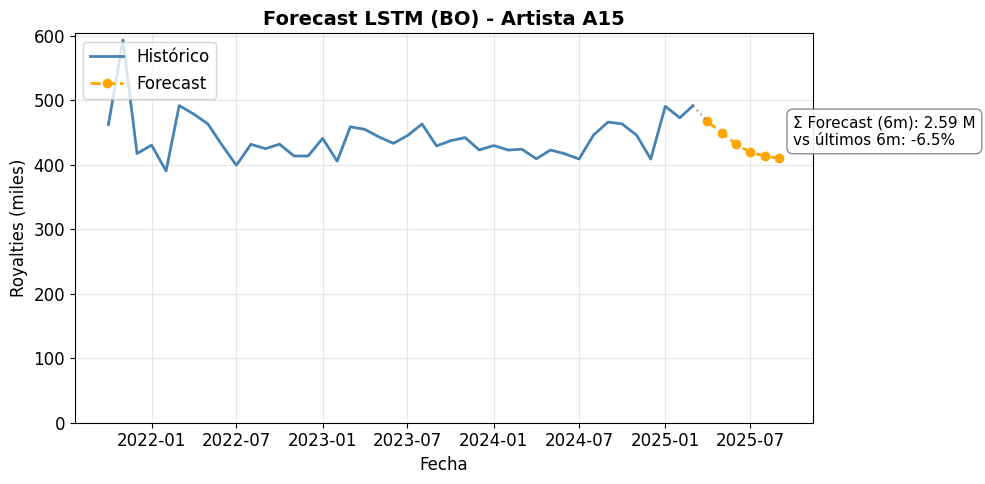

In [6]:
# ==============================
# Gráficos (sin guardar) + Σ Forecast y vs últimos 6m
# ==============================
def graficar_lstm(df_hist, lista_forecasts):
    """
    Muestra un gráfico por artista en pantalla, sin guardar.
    Usa SOLO Matplotlib para evitar warnings de converter.
    Añade:
      - Σ Forecast (6m)
      - vs últimos 6m históricos (%)
      - línea de unión último real → primer forecast
    """
    for fc in lista_forecasts:
        if fc.empty:
            continue
        artist_id = fc["artist_id"].iloc[0]

        g_hist = df_hist[df_hist["artist_id"] == artist_id].sort_values("fecha").copy()
        if g_hist.empty:
            continue

        # preparar series históricas
        g_hist["fecha"] = pd.to_datetime(g_hist["fecha"])
        g_hist = g_hist.set_index("fecha").asfreq("MS")
        y = g_hist["royalties"]

        # forecast
        fc_plot = (fc.sort_values("fecha_prediccion")
                     .set_index("fecha_prediccion")["royalties_forecast"])

        # escala automática
        max_val = max(y.max(), fc_plot.max())
        scale, y_label = _human_scale(max_val)

        # convertir a objetos datetime puros
        x_hist = y.index.to_pydatetime()
        y_hist = (y/scale).values
        x_fc   = fc_plot.index.to_pydatetime()
        y_fc   = (fc_plot/scale).values

        fig, ax = plt.subplots(figsize=(10,5))

        # histórico
        ax.plot(x_hist, y_hist, label="Histórico", color="steelblue", linewidth=2)

        # forecast
        ax.plot(x_fc, y_fc, label="Forecast", color="orange",
                marker="o", linestyle="--", linewidth=2)

        # unión último real → primer forecast
        ax.plot([x_hist[-1], x_fc[0]], [y_hist[-1], y_fc[0]],
                color="gray", linestyle=":", alpha=0.7)

        # sumatorias
        yhat_sum = float(np.clip(fc_plot.values, 0, None).sum())
        last6_hist_sum = float(y.tail(6).sum()) if len(y) >= 6 else np.nan
        pct_vs_last6 = (yhat_sum / last6_hist_sum - 1.0) * 100.0 \
                       if np.isfinite(last6_hist_sum) and last6_hist_sum > 0 else np.nan

        resumen = f"Σ Forecast (6m): {_fmt_money(yhat_sum)}"
        if np.isfinite(pct_vs_last6):
            signo = "+" if pct_vs_last6 >= 0 else ""
            resumen += f"\nvs últimos 6m: {signo}{pct_vs_last6:.1f}%"

        ax.annotate(resumen, xy=(x_fc[-1], y_fc[-1]),
                    xytext=(10, 10), textcoords="offset points",
                    fontsize=11,
                    bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.9))

        ax.set_title(f"Forecast LSTM (BO) - Artista {artist_id}", fontsize=14, weight="bold")
        ax.set_xlabel("Fecha"); ax.set_ylabel(y_label)
        ax.legend(loc="upper left")
        ax.set_ylim(bottom=0)
        ax.grid(True, which="both", color="#e6e6e6", linestyle="-", linewidth=0.8, alpha=1.0)
        plt.tight_layout()
        plt.show()


# ==============================
# Gráficos (cuando quieras), sin guardar imágenes
# ==============================
graficar_lstm(df, lista_forecasts)
